# **Data Cleaning Notebook**

## Objectives
- Evaluate missing data
- Clean data

## Inputs

*   outputs/datasets/collection/Co2Emissions.csv

## Outputs

* - Data Cleaning Pipeline



# Install python packages in the notebooks

In [1]:
%pip install -r /workspace/pp5_co2_oracle/requirements.txt

You should consider upgrading via the '/home/gitpod/.pyenv/versions/3.8.16/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


# Change working directory

We need to change the working directory from its current folder to its parent folder
-    We access the current directory with os.getcwd()

In [2]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/pp5_co2_oracle/jupyter_notebooks'

We want to make the parent of the current directory the new current directory.
- os.path.dirname() gets the parent directory
- os.chir() defines the new current directory

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [4]:
current_dir = os.getcwd()
current_dir

'/workspace/pp5_co2_oracle'

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18974 entries, 200 to 63103
Data columns (total 10 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Country                               18974 non-null  object 
 1   Year                                  18974 non-null  int64  
 2   Total                                 18974 non-null  object 
 3   Coal                                  18974 non-null  object 
 4   Oil                                   18974 non-null  object 
 5   Gas                                   18974 non-null  object 
 6   Cement                                18974 non-null  object 
 7   Flaring                               18974 non-null  object 
 8   Other                                 18974 non-null  object 
 9   Per Capita                            18974 non-null  float64
dtypes: float64(1), int64(1), object(8)
memory usage: 1.6+ MB


## Load Collected data

In [7]:
# Display column names
print(df.columns)


Index(['Country                             ', 'Year ', 'Total        ',
       'Coal         ', 'Oil          ', 'Gas         ', 'Cement      ',
       'Flaring    ', 'Other      ', 'Per Capita'],
      dtype='object')


In [39]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Define the path to your raw CSV file
df_raw_path = "outputs/datasets/collection/Co2Emissions.csv"

# Read the CSV file into a DataFrame
df = pd.read_csv(df_raw_path)

# Clean column names by stripping extra whitespace
df.columns = df.columns.str.strip()

# Display the cleaned column names and data types
print("Cleaned Columns in DataFrame:", df.columns)
print("Data Types:", df.dtypes)

# Keep the original 'Country' column
df['Country_Original'] = df['Country']

# Check if the 'Country' column is present and apply Label Encoding
if 'Country' in df.columns:
    # Initialize the LabelEncoder
    le = LabelEncoder()
    
    # Apply Label Encoding to the 'Country' column
    df['Country'] = le.fit_transform(df['Country'])
else:
    print("Column 'Country' not found in the DataFrame.")

# Convert 'Country' to categorical data type
df['Country'] = df['Country'].astype('category')

# Inspect the 'Other' column
print("Unique values in 'Other' column:")
print(df['Other'].unique())

# Replace empty strings with NaN and convert to numeric
df['Other'].replace('', pd.NA, inplace=True)
df['Other'] = pd.to_numeric(df['Other'], errors='coerce')

# Handle missing values in 'Other' by filling with the median
df['Other'] = df['Other'].fillna(df['Other'].median())

# Ensure all columns in numeric_cols are numeric
numeric_cols = ['Year', 'Total', 'Coal', 'Oil', 'Gas', 'Cement', 'Flaring', 'Other', 'Per Capita']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Fill missing values in numeric columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

# Initialize the StandardScaler
scaler = StandardScaler()

# Scale the numeric columns, except 'Year'
df_scaled = df.copy()  # Create a copy to avoid modifying the original DataFrame
df_scaled[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# Ensure 'Year' column remains unscaled
df_scaled['Year'] = df['Year']

# Display the transformed DataFrame
print("Transformed DataFrame:")
print(df_scaled.head())





Cleaned Columns in DataFrame: Index(['Country', 'Year', 'Total', 'Coal', 'Oil', 'Gas', 'Cement', 'Flaring',
       'Other', 'Per Capita'],
      dtype='object')
Data Types: Country        object
Year            int64
Total          object
Coal           object
Oil            object
Gas            object
Cement         object
Flaring        object
Other          object
Per Capita    float64
dtype: object
Unique values in 'Other' column:
['           ' '2.242063   ' '2.229622   ' ... '306.638573 ' '296.301685 '
 '296.145746 ']
Transformed DataFrame:
  Country  Year     Total      Coal       Oil       Gas    Cement   Flaring  \
0       0  1750 -0.066846 -0.071869 -0.061621 -0.055383 -0.049059 -0.059631   
1       0  1751 -0.066846 -0.071869 -0.061621 -0.055383 -0.049059 -0.059631   
2       0  1752 -0.066846 -0.071869 -0.061621 -0.055383 -0.049059 -0.059631   
3       0  1753 -0.066846 -0.071869 -0.061621 -0.055383 -0.049059 -0.059631   
4       0  1754 -0.066846 -0.071869 -0.061621 -0.05

## Data Exploration

- In Data Cleaning I'm interested to check the distribution and shape of a variable with missing data.

In [40]:
vars_with_missing_data = df.columns[df.isna().sum() > 0].to_list()
vars_with_missing_data

[]

In [41]:
from ydata_profiling import ProfileReport
if vars_with_missing_data:
    profile = ProfileReport(df=df[vars_with_missing_data], minimal=True)
    profile.to_notebook_iframe()
else:
    print("There are no variables with missing data")

There are no variables with missing data


## Correlation and PPS Analysis

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore as pps

# Strip any leading/trailing spaces from column names
df.columns = df.columns.str.strip()


def heatmap_corr(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=bool)
        mask[np.triu_indices_from(mask)] = True
        mask[abs(df) < threshold] = True

        fig, axes = plt.subplots(figsize=figsize)
        sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                    mask=mask, cmap='viridis', annot_kws={"size": font_annot}, ax=axes,
                    linewidth=0.5
                    )
        axes.set_yticklabels(df.columns, rotation=0)
        plt.ylim(len(df.columns), 0)
        plt.show()


def heatmap_pps(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=bool)
        mask[abs(df) < threshold] = True
        fig, ax = plt.subplots(figsize=figsize)
        ax = sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                         mask=mask, cmap='rocket_r', annot_kws={"size": font_annot},
                         linewidth=0.05, linecolor='grey')
        plt.ylim(len(df.columns), 0)
        plt.show()


def CalculateCorrAndPPS(df):
    df_corr_spearman = df.corr(method="spearman")
    df_corr_pearson = df.corr(method="pearson")

    pps_matrix_raw = pps.matrix(df)
    pps_matrix = pps_matrix_raw.filter(['x', 'y', 'ppscore']).pivot(columns='x', index='y', values='ppscore')

    pps_score_stats = pps_matrix_raw.query("ppscore < 1").filter(['ppscore']).describe().T
    print("PPS threshold - check PPS score IQR to decide threshold for heatmap \n")
    print(pps_score_stats.round(3))

    return df_corr_pearson, df_corr_spearman, pps_matrix


def DisplayCorrAndPPS(df_corr_pearson, df_corr_spearman, pps_matrix, CorrThreshold, PPS_Threshold,
                      figsize=(20, 12), font_annot=8):

    print("\n")
    print("* Analyse how the target variable for your ML models are correlated with other variables (features and target)")
    print("* Analyse multi-colinearity, that is, how the features are correlated among themselves")

    print("\n")
    print("*** Heatmap: Spearman Correlation ***")
    print("It evaluates monotonic relationship \n")
    heatmap_corr(df=df_corr_spearman, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Pearson Correlation ***")
    print("It evaluates the linear relationship between two continuous variables \n")
    heatmap_corr(df=df_corr_pearson, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Power Predictive Score (PPS) ***")
    print(f"PPS detects linear or non-linear relationships between two columns.\n"
          f"The score ranges from 0 (no predictive power) to 1 (perfect predictive power) \n")
    heatmap_pps(df=pps_matrix, threshold=PPS_Threshold, figsize=figsize, font_annot=font_annot)



Calculate Correlations and Power Predictive Score

In [43]:
df_corr_pearson, df_corr_spearman, pps_matrix = CalculateCorrAndPPS(df)

PPS threshold - check PPS score IQR to decide threshold for heatmap 

         count   mean    std  min  25%    50%    75%    max
ppscore  108.0  0.124  0.191  0.0  0.0  0.006  0.223  0.714


Display the heatmaps



* Analyse how the target variable for your ML models are correlated with other variables (features and target)
* Analyse multi-colinearity, that is, how the features are correlated among themselves


*** Heatmap: Spearman Correlation ***
It evaluates monotonic relationship 



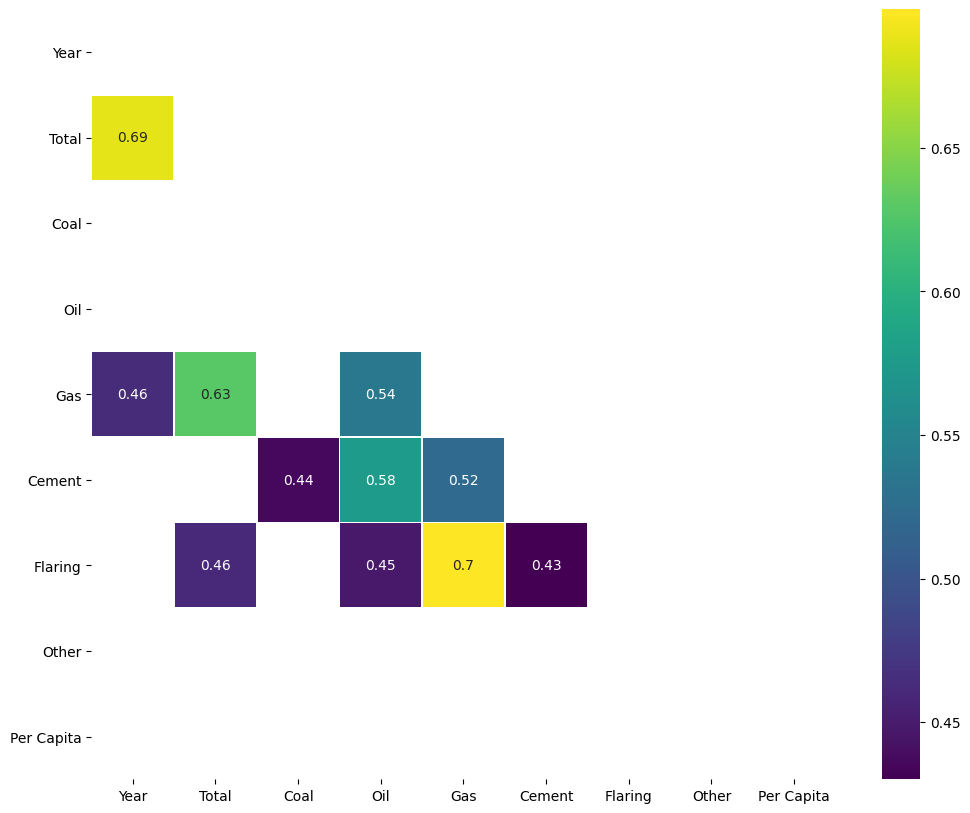



*** Heatmap: Pearson Correlation ***
It evaluates the linear relationship between two continuous variables 



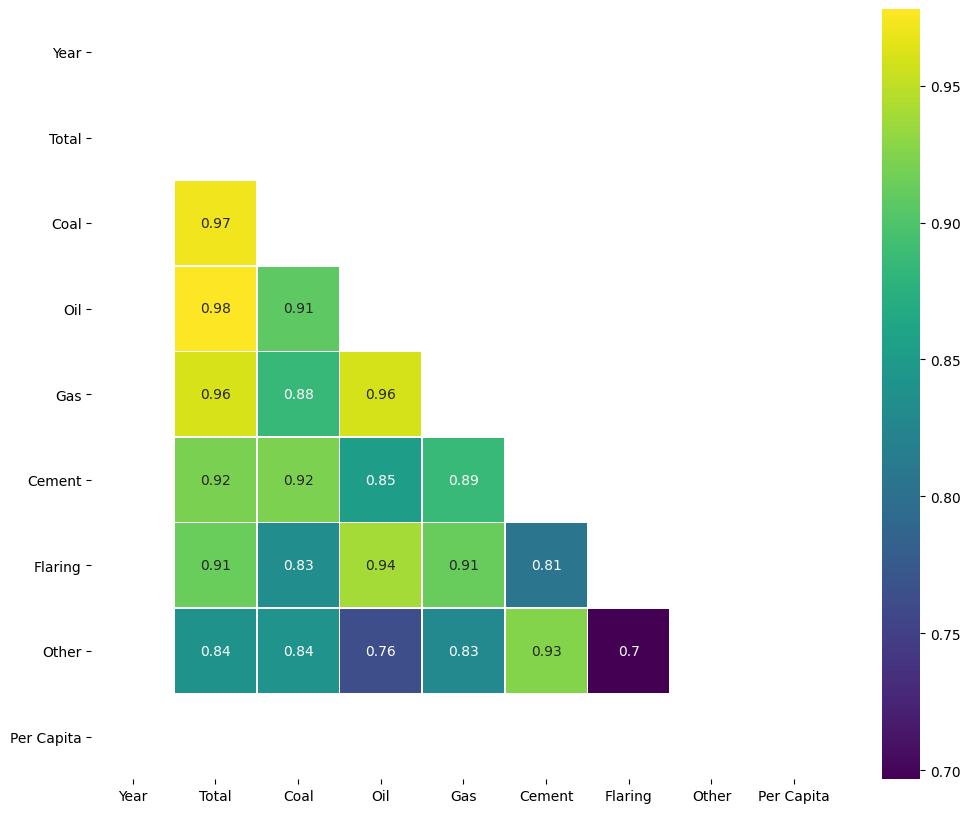



*** Heatmap: Power Predictive Score (PPS) ***
PPS detects linear or non-linear relationships between two columns.
The score ranges from 0 (no predictive power) to 1 (perfect predictive power) 



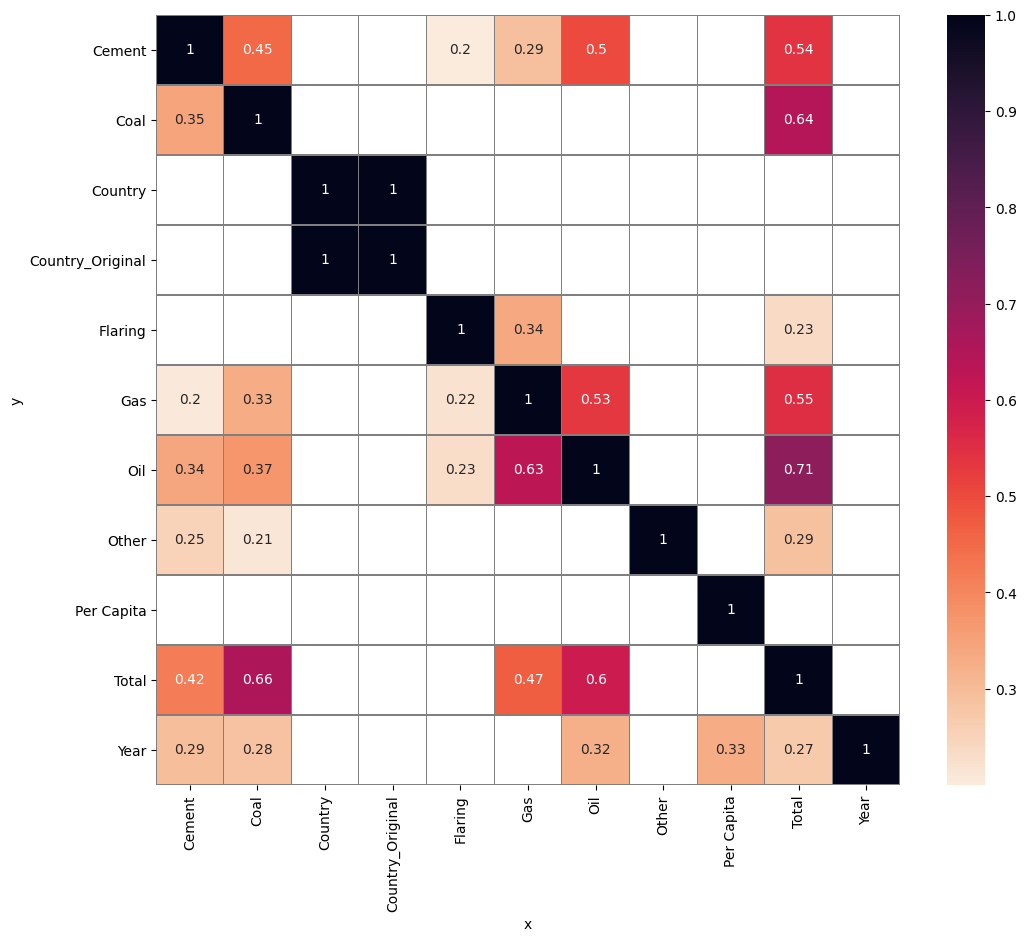

In [44]:
DisplayCorrAndPPS(df_corr_pearson = df_corr_pearson,
                  df_corr_spearman = df_corr_spearman, 
                  pps_matrix = pps_matrix,
                  CorrThreshold = 0.4, PPS_Threshold =0.2,
                  figsize=(12,10), font_annot=10)

## Assessing Missing Data Levels

- Custom function to display missing data levels in a DataFrame, it shows the absolute levels, relative levels and data type.

In [45]:
def EvaluateMissingData(df):
    missing_data_absolute = df.isnull().sum()
    missing_data_percentage = round(missing_data_absolute/len(df)*100, 2)
    df_missing_data = (pd.DataFrame(
                            data={"RowsWithMissingData": missing_data_absolute,
                                   "PercentageOfDataset": missing_data_percentage,
                                   "DataType": df.dtypes}
                                    )
                          .sort_values(by=['PercentageOfDataset'], ascending=False)
                          .query("PercentageOfDataset > 0")
                          )

    return df_missing_data

- Check missing data levels for the collected dataset.

In [46]:
EvaluateMissingData(df)

,RowsWithMissingData,PercentageOfDataset,DataType


## Split Train and Test Set

In [47]:
from sklearn.model_selection import train_test_split
TrainSet, TestSet, _, __ = train_test_split(
                                        df,
                                        df['Country'],
                                        test_size=0.2,
                                        random_state=0)

print(f"TrainSet shape: {TrainSet.shape} \nTestSet shape: {TestSet.shape}")

TrainSet shape: (50483, 11) 
TestSet shape: (12621, 11)


In [48]:
df_missing_data = EvaluateMissingData(TrainSet)
print(f"* There are {df_missing_data.shape[0]} variables with missing data \n")
df_missing_data

* There are 0 variables with missing data 



,RowsWithMissingData,PercentageOfDataset,DataType


## Push cleaned data to Repo

In [49]:
import os
try:
  os.makedirs(name='outputs/datasets/cleaned') # create outputs/datasets/collection folder
except Exception as e:
  print(e)

## Train Set

In [50]:
TrainSet.to_csv("outputs/datasets/cleaned/TrainSetCleaned.csv", index=False)

## Test Set

In [51]:
TestSet.to_csv("outputs/datasets/cleaned/TestSetCleaned.csv", index=False)